In [2]:
from simtk import unit
from openmm import app
from openmm import *
from openmm.app import *
from mdtraj.reporters import HDF5Reporter
import os
import logging
import pickle
import mdtraj as md
from copy import deepcopy




In [3]:
def sim(parmed_obj,T_kelvin,name,t_ns):

    # Configure logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)


    temperature = T_kelvin * unit.kelvin
    pressure = 1.013 * unit.bar
    time_step = 0.002 * unit.picoseconds

    file_path="."
    file_name = f'{name}_T_{T_kelvin}_t_{t_ns}'
    platform="CUDA"
    num_steps=5000 * 100 * t_ns
    write_out_freq=500
    constrain_all_bonds=True

                    
    logger.info("Starting simulation via OpenMM")
    platform = Platform.getPlatformByName(platform)
    pmd = parmed_obj
    path = '{}/{}.h5'.format(file_path, file_name)

    constrain_what_bond = app.AllBonds if constrain_all_bonds else app.HBonds
    system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond, rigidWater=False)

    logger.info("Adding thermostat and barostat")
    thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
    system.addForce(thermostat)
    barostat = MonteCarloBarostat(pressure, temperature)
    system.addForce(barostat)
    integrator = VerletIntegrator(time_step)

    simulation = Simulation(pmd.topology, system, integrator, platform)
    simulation.context.setPeriodicBoxVectors(*pmd.box_vectors)
    simulation.context.setPositions(pmd.positions)
    simulation.minimizeEnergy()
    logger.info("Energy minimized")


    state = simulation.context.getState(getPositions=True, getVelocities=True)
    pmd.positions, pmd.velocities, pmd.box_vectors = state.getPositions(), state.getVelocities(), state.getPeriodicBoxVectors()

    # Production
    del system
    del simulation

    system = pmd.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1*unit.nanometer, constraints=constrain_what_bond)
    thermostat = AndersenThermostat(temperature, 1/unit.picosecond)
    system.addForce(thermostat)

    integrator = VerletIntegrator(time_step)
    simulation = Simulation(pmd.topology, system, integrator, platform)

    pmd_copy = deepcopy(pmd)
    pmd_copy_box = pmd_copy.box
    pmd_copy_box[2] = pmd_copy_box[2] * 5
    pmd_copy.box = pmd_copy_box

    simulation.context.setPeriodicBoxVectors(*pmd_copy.box_vectors)
    simulation.context.setPositions(pmd.positions)
    simulation.reporters.append(StateDataReporter("{}/production_{}.dat".format(file_path, file_name), num_steps//50000, step=True, potentialEnergy=True, temperature=True, density=True,kineticEnergy=True,totalEnergy=True,volume=True))
    simulation.reporters.append(HDF5Reporter(path, write_out_freq))
    simulation.step(num_steps)
    logger.info("Production complete")


In [4]:
#find all conf_ids that are NOT in cs_mdfps_schema.confid_data;
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=scotland")
cur = conn.cursor()
query = """

SELECT 
    e.molregno,
    c.conf_id,
    e.vp_log10_pa,
    m.mdfp,
    c.molblock,
    m.md_experiment_uuid,
    cd.confgen_uuid -- Add this column for confgen_uuid
FROM 
    cs_mdfps_schema.experimental_data e
JOIN 
    conformers c ON e.molregno = c.molregno
LEFT JOIN 
    cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id
LEFT JOIN 
    cs_mdfps_schema.confid_data cd ON c.conf_id = cd.conf_id; -- Join with confid_data for confgen_uuid


"""

cur.execute(query)
data = cur.fetchall()
import pandas as pd

df = pd.DataFrame(data, columns=['molregno', 'conf_id', 'vp_log10_pa', 'mdfp', 'molblock', 'md_experiment_uuid', 'confgen_uuid'])
df

df = df[df['md_experiment_uuid'] == '24e3946b-fb2c-47bf-9965-1682bb0d63c9']
df = df.dropna(subset=['mdfp'])
df


,molregno,conf_id,vp_log10_pa,mdfp,molblock,md_experiment_uuid,confgen_uuid
3263,2414,2412,-3.309299,"{'mdfp': '[17, 3, 3, 0, 0, 0, 0, 0, 0, 0, -110...",[H]c1c(C([H])([H])[H])nc(N([H])c2c([H])c([H])c...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
3264,2422,2420,3.031002,"{'mdfp': '[7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 226.3...",[H]c1nc([H])c(C([H])([H])[H])nc1[H]\n RDKi...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
3265,2399,2397,-3.979000,"{'mdfp': '[19, 1, 0, 0, 0, 0, 0, 7, 0, 0, -18....",[H]c1c(Cl)c(Cl)c(Cl)c(-c2c([H])c(Cl)c(Cl)c(Cl)...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
3266,44,1187,3.830901,"{'mdfp': '[5, 2, 0, 0, 0, 0, 1, 0, 0, 0, 4.332...",[H]C([H])([H])SC([H])([H])C([H])([H])C([H])([H...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
3267,75,1218,3.931102,"{'mdfp': '[6, 2, 1, 3, 0, 0, 0, 0, 0, 0, -31.8...",[H]C([H])([H])C([H])([H])O[N+](=O)[O-]\n R...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,906589dd-76fa-4d7b-aa9f-1ee90abe3835
...,...,...,...,...,...,...,...
18088,16996,16994,0.776202,"{'mdfp': '[13, 0, 0, 1, 0, 0, 0, 0, 0, 0, -67....",[H]Oc1c(C([H])([H])[H])c([H])c(C([H])([H])[H])...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,2153b1f8-cb83-4974-86a3-249f49ab55b7
18089,3394,17254,2.296000,"{'mdfp': '[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -24.7...",[H]O[C@]1([H])C([H])([H])C([H])([H])C([H])([H]...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,2153b1f8-cb83-4974-86a3-249f49ab55b7
18090,17082,17080,-6.890598,"{'mdfp': '[20, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0...",[H]c1c([H])c([H])c2c([H])c3c(c([H])c2c1[H])-c1...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,2153b1f8-cb83-4974-86a3-249f49ab55b7
18091,16763,16761,-4.275198,"{'mdfp': '[27, 7, 0, 5, 0, 0, 0, 0, 0, 0, -203...",[H]C([H])=C([H])/C([H])=C(\[H])C([H])([H])C1=C...,24e3946b-fb2c-47bf-9965-1682bb0d63c9,2153b1f8-cb83-4974-86a3-249f49ab55b7


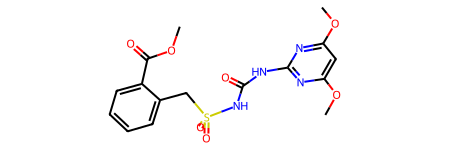

In [5]:
#sort df by vp_log10_pa
from rdkit import Chem
df = df.sort_values('vp_log10_pa')
df
#get top molblock
molblock = df.iloc[0]['molblock']
mol = Chem.MolFromMolBlock(molblock)
mol

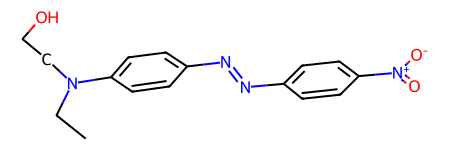

In [7]:
molblock2 = df.iloc[1]['molblock']
mol2 = Chem.MolFromMolBlock(molblock2)
mol2

In [9]:
Chem.MolToSmiles(mol2)

'CCN(CCO)c1ccc(/N=N/c2ccc([N+](=O)[O-])cc2)cc1'

In [6]:
#lets parameterize this molecule
#add .. to path
import sys
sys.path.append("..")
from Parameteriser import LiquidParameteriser
rdk_pmd = LiquidParameteriser.via_rdkit(smiles = Chem.MolToSmiles(mol))
#save as pickle
import pickle
with open('low_vp_mol.pkl', 'wb') as f:
    pickle.dump(rdk_pmd, f)


Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



2024-07-31 14:49:01,156 - INFO - Running parameterisation for SMILES: COC(=O)c1ccccc1CS(=O)(=O)NC(=O)Nc1nc(OC)cc(OC)n1 with density: 0.95 g/mL and 256 molecules.
2024-07-31 14:49:01,157 - INFO - Creating substance and workflow schema.
2024-07-31 14:49:01,205 - INFO - Executing workflow.
2024-07-31 14:49:01,303 - INFO - Executing ff0a05d237b8456c8c50241238892001|build_coordinates


KeyboardInterrupt: 

In [13]:
#let simulate this guy at 3 temperatures
for T in [300, 350, 450]:
    sim(rdk_pmd, T, 'low_vp_mol', 5)


2024-07-31 13:14:51,999 - INFO - Starting simulation via OpenMM
2024-07-31 13:14:52,097 - INFO - Adding bonds...
2024-07-31 13:14:52,110 - INFO - Adding angles...
2024-07-31 13:14:52,132 - INFO - Adding dihedrals...
2024-07-31 13:14:52,172 - INFO - Adding Ryckaert-Bellemans torsions...
2024-07-31 13:14:52,172 - INFO - Adding Urey-Bradleys...
2024-07-31 13:14:52,172 - INFO - Adding improper torsions...
2024-07-31 13:14:52,172 - INFO - Adding CMAP torsions...
2024-07-31 13:14:52,173 - INFO - Adding trigonal angle terms...
2024-07-31 13:14:52,173 - INFO - Adding out-of-plane bends...
2024-07-31 13:14:52,173 - INFO - Adding pi-torsions...
2024-07-31 13:14:52,173 - INFO - Adding stretch-bends...
2024-07-31 13:14:52,174 - INFO - Adding torsion-torsions...
2024-07-31 13:14:52,174 - INFO - Adding Nonbonded force...
2024-07-31 13:14:52,572 - INFO - Adding thermostat and barostat
2024-07-31 13:15:01,551 - INFO - Energy minimized
2024-07-31 13:15:01,724 - INFO - Adding bonds...
2024-07-31 13:15:0

In [1]:
sim(rdk_pmd, 450, 'low_vp_mol', 5)


NameError: name 'sim' is not defined